# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [100]:
!nvidia-smi

Wed Dec 28 20:56:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    48W / 400W |  22316MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [101]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torchaudio.transforms as tat

from sklearn.metrics import accuracy_score
import gc

import zipfile
import datetime

# imports for decoding and distance calculation
# import ctcdecode
# import Levenshtein
# from ctcdecode import CTCBeamDecoder

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [126]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 96,
    'epochs': 70,
    'lr': 1e-3
}

# Toy Data Setup

The toy dataset is very essential for you in this HW. The model which you will be building is complicated and you first need to make sure that it runs on the toy dataset. <br>
In other words, you need convergence - the attention diagonal. Take a look at the write-up for this. <br>
We have given you the following code to download the toy data and load it. You can use it the way it is. But be careful, the transcripts are different from the original data from kaggle. The toy dataset has phonemes but the actual data has characters.

In [ ]:
!wget -q https://cmu.box.com/shared/static/wok08c2z2dp4clufhy79c5ee6jx3pyj9 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/zctr6mvh7npfn01forli8n45duhp2g85 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/m2oaek69145ljeu6srtbbb7k0ip6yfup --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/owrjy0tqra3v7zq2ru7mocy2djskydy9 --content-disposition --show-progress

f0176_mfccs_train.n 100%[===================>] 279.30M  10.2MB/s    in 31s     
f0176_mfccs_dev.npy 100%[===================>]  27.93M  15.2MB/s    in 1.8s    
f0176_hw3p2_train.n 100%[===================>]   7.02M  --.-KB/s    in 0.09s   
f0176_hw3p2_dev.npy 100%[===================>] 718.88K  --.-KB/s    in 0.009s  


In [ ]:
# Load the toy dataset
X_train = np.load("f0176_mfccs_train.npy")
X_valid = np.load("f0176_mfccs_dev.npy")
Y_train = np.load("f0176_hw3p2_train.npy")
Y_valid = np.load("f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP["[PAD]"]  = len(VOCAB_MAP)
VOCAB               = list(VOCAB_MAP.keys())

SOS_TOKEN = VOCAB_MAP["[SOS]"]
EOS_TOKEN = VOCAB_MAP["[EOS]"]
PAD_TOKEN = VOCAB_MAP["[PAD]"]

Y_train = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_valid]

ValueError: ignored

In [ ]:
# Dataset class for the Toy dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train[:, :, :15]
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid[:, :, :15]
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

# Kaggle Data

In [ ]:
# TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"whchoihw","key":"47096e661519dd97c4033097910a6d09"}') # TODO: Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 3.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73274 sha256=464567ac0a3ba129504c6b5d55167aae53469556d72b92a5f963b9260b21f9df
  Stored in directory: /root/.cache/pip/wheels/f3/67/7b/a6d668747974998471d29b230e7221dd01330ac34faebe4af4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

100% 2.08G/2.09G [00:20<00:00, 171MB/s]
100% 2.09G/2.09G [00:20<00:00, 110MB/s]


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
# TODO: Create a dataset class which is exactly the same as HW3P2. You are free to reuse it. 
# The only change is that the transcript mapping is different for this HW.
# Note: We also want to retain SOS and EOS tokens in the transcript this time.
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, root, partition="", transforms=[]): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = root + partition + '/mfcc'
        self.transcript_dir = root + partition + '/transcript/raw'
        
        idx = int(len(os.listdir(self.mfcc_dir))*1)
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))[:idx]
        print(len(self.mfcc_files))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))[:idx]


        self.mfcc = [np.load(self.mfcc_dir+'/'+file) for file in self.mfcc_files]
        self.length = len(self.mfcc)
        self.VOCAB_MAP = VOCAB_MAP

        self.transcript_before = [np.load(self.transcript_dir+'/'+file) for file in self.transcript_files]

        self.transcript = []
        for t in self.transcript_before:
          self.transcript.append([self.VOCAB_MAP[p] for p in t])

        self.transforms = transforms
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        # raise NotImplemented

        mfcc = torch.FloatTensor(self.mfcc[ind]) # TODO
        mfcc = (mfcc - mfcc.mean(axis=0))/mfcc.std(axis=0)

        transcript = torch.LongTensor(self.transcript[ind])

        return mfcc, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batches
        batch_mfcc = [x for x,y in batch]
        batch_transcript = [y for x,y in batch]


        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True, padding_value=0)
        lengths_mfcc = [int(i.shape[0]) for i in batch_mfcc]

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True, padding_value=0) # TODO
        lengths_transcript = [int(i.shape[0]) for i in batch_transcript] # TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        if self.transforms:
          batch_mfcc_pad = self.transforms(batch_mfcc_pad)

        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
# TODO: Similarly, create a test dataset class
# Test Dataloader
#TODO
class AudioDatasetTest(torch.utils.data.Dataset):

    #TODO
    def __init__(self, root, partition="", transforms=[]): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = root + partition + '/mfcc'
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.length = len(self.mfcc_files)
        

        self.mfcc = [np.load(self.mfcc_dir+'/'+file) for file in self.mfcc_files]

        self.transforms = transforms

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        # raise NotImplemented

        mfcc = torch.FloatTensor(self.mfcc[ind])
        mfcc = (mfcc - mfcc.mean(axis=0))/mfcc.std(axis=0)
        return mfcc

    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [x for x in batch] # TODO

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True, padding_value=0) # TODO
        lengths_mfcc = [int(i.shape[0]) for i in batch_mfcc]
        
        if self.transforms:
          batch_mfcc_pad = self.transforms(batch_mfcc_pad)
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

# Dataset and Dataloaders

In [104]:
# TODO: Create the datasets and dataloaders
# All these things are similar to HW3P2
# You can reuse the same code

# The sanity check for shapes also are similar
# Please remember that the only change in the dataset for this HW is the transcripts
# So you are expected to get similar shapes like HW3P2 (Pad, pack and Oh my!)

BATCH_SIZE = 128 # Increase if your device can handle it

#transforms = torch.nn.Sequential(torchaudio.transforms.FrequencyMasking(freq_mask_param=1),
#              torchaudio.transforms.TimeMasking(time_mask_param=5, p=0.3)) # set of tranformations

# You may pass this as a parameter to the dataset class above
# This will help modularize your implementation

# root = '/content/drive/MyDrive/IDL/HW4/data/hw4p2/' 
root = '/content/data/hw4p2/' 

In [105]:
# get me RAMMM!!!! 
import gc 
gc.collect()

2177

In [ ]:
transforms = []

### Toy loader

In [ ]:
toy_transcripts_train = np.load('/content/f0176_hw3p2_train.npy')
toy_mfccs_train = np.load('/content/f0176_mfccs_train.npy')

In [ ]:
toy_transcripts_test = np.load('/content/f0176_hw3p2_dev.npy')
toy_mfccs_test = np.load('/content/f0176_mfccs_dev.npy')

### Real loader

In [ ]:
# Create objects for the dataset class
train_data = AudioDataset(root = root, partition = 'train-clean-100', transforms= transforms) #TODO
val_data = AudioDataset(root = root, partition = 'dev-clean', transforms = transforms) # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest(root = root, partition = 'test-clean', transforms = transforms) #TODO

28539
2703


In [106]:
# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(train_data, num_workers= 4,
                                           batch_size=BATCH_SIZE, collate_fn = train_data.collate_fn,
                                           shuffle= True)
val_loader = torch.utils.data.DataLoader(val_data, num_workers= 2,
                                         batch_size=BATCH_SIZE, collate_fn = val_data.collate_fn,
                                         shuffle= False)
test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, 
                                          batch_size=BATCH_SIZE, collate_fn = test_data.collate_fn, 
                                          shuffle= False)

print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [129]:
# sanity check
for data in val_loader:
    x, y, lx, ly = data
    print(lx[0])
    print(len(x))
    print(x.shape, y.shape, lx.shape, ly.shape)
    break 

tensor(205)
128
torch.Size([128, 2707, 15]) torch.Size([128, 309]) torch.Size([128]) torch.Size([128])


In [108]:
for data in test_loader:
    x, lx= data
    print(x.shape, lx.shape)
    break 

torch.Size([128, 3000, 15]) torch.Size([128])


In [ ]:
y[1]

tensor([ 0, 18, 15, 19,  5, 28,  8,  9,  7,  8, 28,  1, 14,  4, 28, 12, 15, 21,
         4, 28, 23,  8,  9, 12,  5, 28,  1, 28,  7, 18,  5,  1, 20, 28, 20,  8,
        21, 14,  4,  5, 18,  9, 14,  7, 28,  1, 20, 28, 20,  8,  5, 28,  6, 18,
        15, 14, 20, 28,  4, 15, 15, 18, 28, 15,  6, 28, 20,  8,  5, 28,  3,  8,
        21, 18,  3,  8, 28,  1, 14, 14, 15, 21, 14,  3,  5,  4, 28, 20,  8,  1,
        20, 28, 20,  8,  5, 28, 16,  5, 15, 16, 12,  5, 28,  2,  5, 12, 15, 23,
        28,  8,  1,  4, 28,  1, 12, 19, 15, 28,  3,  1, 21,  7,  8, 20, 28, 20,
         8,  5, 28, 19, 15, 21, 14,  4, 28, 15,  6, 28, 20,  8,  5, 28, 13, 21,
        19,  9,  3, 28,  1, 14,  4, 28, 23,  5, 18,  5, 28,  3, 12,  1, 13, 15,
        18, 15, 21, 19, 28,  6, 15, 18, 28,  1,  4, 13,  9, 19, 19,  9, 15, 14,
        29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [ ]:
ly[1]

tensor(181)

# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


In [109]:
class LockedDropout(torch.nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        # T, B, C -> B, T, C
        x = x.clone()
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'

## Encoder

### Pyramidal Bi-LSTM

In [110]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        self.blstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=1, \
                                   dropout=0.2, bidirectional=True, batch_first = True)
        
        self.dropout = LockedDropout(p=0.2)


    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        x_padded, x_padded_length = pad_packed_sequence(x_packed, batch_first=True)
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x_trunc, x_trunc_length = self.trunc_reshape(x_padded, x_padded_length)
        out = self.dropout(x_trunc)
        
        # TODO: Pack Padded Sequence. What output(s) would you get?
        x_packed = pack_padded_sequence(out, x_trunc_length, 
                                        batch_first=True, 
                                        enforce_sorted=False)
        
        # TODO: Pass the sequence through bLSTM
        out, _ = self.blstm(x_packed)


        # What do you return?

        return out

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        B, L, D = x.shape
    
        x = x[:, :(L//2)*2, :]
        

        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape(B, L // 2, D * 2)

        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens // 2

        return x, x_lens

### Listener

In [111]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        # The first LSTM at the very bottom
        # The first LSTM at the very bottom
        self.base_lstm1 = torch.nn.LSTM(input_size=input_size, hidden_size=encoder_hidden_size//2, bidirectional=True, batch_first=True, num_layers=1, dropout=0.2)
        self.base_lstm2 = torch.nn.LSTM(input_size=encoder_hidden_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, num_layers=1)
        self.base_lstm3 = torch.nn.LSTM(input_size=encoder_hidden_size*2, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, num_layers=1)
        
        self.locked_dropout1 = LockedDropout(p=0.1)
        self.locked_dropout2 = LockedDropout(p=0.1)
        self.locked_dropout3 = LockedDropout(p=0.1)

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be? 
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),
            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),
            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),
        )
         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        
        # TODO: Pack Padded Sequence
        # TODO: Pass it through the first LSTM layer (no truncation)
        # TODO: Pad Packed Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer

        out = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        out, hidden = self.base_lstm1(out)
        out, out_lens = pad_packed_sequence(out, batch_first=True)
        out = self.locked_dropout1(out)
        
        out = pack_padded_sequence(out, out_lens, batch_first=True, enforce_sorted=False)
        out, hidden = self.base_lstm2(out)
        out, out_lens = pad_packed_sequence(out, batch_first=True)
        out = self.locked_dropout2(out)
        
        out = pack_padded_sequence(out, out_lens, batch_first=True, enforce_sorted=False)
        out, hidden = self.base_lstm3(out)

        out = self.pBLSTMs(out)
        encoder_outputs, encoder_lens = pad_packed_sequence(out, batch_first=True)

        return encoder_outputs, encoder_lens

In [112]:
encoder = Listener(input_size = 15, encoder_hidden_size = 512).to(DEVICE) # TODO: Initialize Listener
print(encoder)
#summary(encoder, example_batch[0].to(DEVICE), example_batch[3])
del encoder

Listener(
  (base_lstm1): LSTM(15, 256, batch_first=True, dropout=0.2, bidirectional=True)
  (base_lstm2): LSTM(512, 512, batch_first=True, bidirectional=True)
  (base_lstm3): LSTM(1024, 512, batch_first=True, bidirectional=True)
  (locked_dropout1): LockedDropout(p=0.1)
  (locked_dropout2): LockedDropout(p=0.1)
  (locked_dropout3): LockedDropout(p=0.1)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, dropout=0.2, bidirectional=True)
      (dropout): LockedDropout(p=0.2)
    )
    (1): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, dropout=0.2, bidirectional=True)
      (dropout): LockedDropout(p=0.2)
    )
    (2): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, dropout=0.2, bidirectional=True)
      (dropout): LockedDropout(p=0.2)
    )
  )
)


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [113]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.projection_size = projection_size

        self.key_projection     = torch.nn.Linear(encoder_hidden_size*2, projection_size) # TODO: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(encoder_hidden_size*2, projection_size) # TODO: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(decoder_output_size, projection_size) # TODO: Define an nn.Linear layer which projects the decoder_output_state to query
        # Optional : Define an nn.Linear layer which projects the context vector

        self.softmax            = torch.nn.Softmax(dim=1) # TODO: Define a softmax layer. Think about the dimension which you need to apply 
        # Tip: What is the shape of energy? And what are those?

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs) # TODO: Project encoder_outputs using key_projection to get keys
        self.value    = self.value_projection(encoder_outputs) # TODO: Project encoder_outputs using value_projection to get values

        # encoder_max_seq_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)

        # TODO: To remove the influence of padding in the raw_weights, we want to create a boolean mask of shape (batch_size, timesteps) 
        # The mask is False for all indicies before padding begins, True for all indices after.
        self.padding_mask     =  torch.arange(encoder_max_seq_len).unsqueeze(0) >= encoder_lens.unsqueeze(1) # TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        self.padding_mask = self.padding_mask.to(DEVICE)
        # (Hint: Broadcasting gives you a one liner)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding) # TODO: Project the query using query_projection

        # Hint: Take a look at torch.bmm for the products below 

        raw_weights        = torch.bmm(self.key, self.query.unsqueeze(2)).squeeze(2) # TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        masked_raw_weights = raw_weights.masked_fill_(self.padding_mask.bool(), -float('inf')) # TODO: Mask the raw_weights with self.padding_mask. 
        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)

        attention_weights  = self.softmax(raw_weights / np.sqrt(self.key.shape[2])) # TODO: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1) # TODO: Calculate the context - it is a product between attention_weights and value

        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [114]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size

        self.embedding          = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size, padding_idx=EOS_TOKEN) 
        # TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  

        self.lstm_cells         = torch.nn.Sequential(
                                # Create Two LSTM Cells as per LAS Architecture
                                # What should the input_size of the first LSTM Cell? 
                                # Hint: It takes in a combination of the character embedding and context from attention
                                    torch.nn.LSTMCell(input_size=decoder_output_size + embed_size, hidden_size=decoder_hidden_size),
                                    torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
                                    torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_output_size),
                                )
                                
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        self.char_prob          = torch.nn.Linear(attention_module.projection_size + decoder_output_size, vocab_size)
        # TODO: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight # Weight tying

        self.attention          = attention_module

        self.dropout = torch.nn.Dropout(0.2)

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells) 

        attention_plot          = []
        context                 = torch.zeros(batch_size, self.attention.projection_size).to(DEVICE) # TODO: Initialize context (You have a few choices, refer to the writeup )
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)


        for t in range(timesteps):
            
            # char_embed = #TODO: Generate the embedding for the character at timestep t

            # if self.training and t > 0:
            #     # TODO: We want to decide which embedding to use as input for the decoder during training
            #     # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
            #     # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
            #     # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use

            #     char_embed = # TODO

            if self.training:
                if random.random() < tf_rate:
                    if t == 0:
                        char_embed = self.embedding(char)
                    else:
                        char_embed = label_embed[:,t-1,:] # t-1
                else:
                    char_embed = self.embedding(char)
            else:
                char_embed = self.embedding(char)
      
            decoder_input_embedding = torch.cat([char_embed, context], dim=1)
            # TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                decoder_input_embedding = hidden_states[i][0]

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat([self.attention.query, context], dim=1)
            # TODO: Concatenate the projected query with context for the output embedding
            # Hint: How can you get the projected query from attention
            # If you are not using attention, what will you use instead of query?

            char_prob            = self.char_prob(output_embedding)
            
            # Append
            predictions.append(char_prob)

            char = char_prob.argmax(dim=1)
            # TODO: Get the predicted character for the next timestep from the probability distribution 
            # (Hint: Use Greedy Decoding for starters)


        attention_plot  = torch.stack(attention_plot, dim=0) # TODO: Stack list of attetion_plots 
        predictions     = torch.stack(predictions, dim=1) # TODO: Stack list of predictions 

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [115]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size, encoder_hidden_size)
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size)
        self.decoder        = Speller(embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module=attention_module)

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [116]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 

model = LAS(input_size=15, 
            encoder_hidden_size=256, 
            vocab_size=30, #len(VOCAB), 
            embed_size=256,
            decoder_hidden_size=512, 
            decoder_output_size=128,
            projection_size= 128
)

model = model.to(DEVICE)
print(model)

# summary(model, 
#         x= example_batch[0].to(DEVICE), 
#         x_lens= example_batch[3], 
#         y= example_batch[1].to(DEVICE))

LAS(
  (encoder): Listener(
    (base_lstm1): LSTM(15, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (base_lstm2): LSTM(256, 256, batch_first=True, bidirectional=True)
    (base_lstm3): LSTM(512, 256, batch_first=True, bidirectional=True)
    (locked_dropout1): LockedDropout(p=0.1)
    (locked_dropout2): LockedDropout(p=0.1)
    (locked_dropout3): LockedDropout(p=0.1)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
        (dropout): LockedDropout(p=0.2)
      )
      (1): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
        (dropout): LockedDropout(p=0.2)
      )
      (2): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
        (dropout): LockedDropout(p=0.2)
      )
    )
  )
  (decoder): Speller(
    (embedding): Embedding(30, 256, padding_idx=29)
    (lstm_cells): Sequential(
      (0): LSTMCell(3

## Optimizer, Scheduler, Loss

In [118]:
optimizer   = torch.optim.AdamW(model.parameters(), lr = config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
scaler      = torch.cuda.amp.GradScaler()

# Optional: Create a custom class for a Teacher Force Schedule 
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, min_lr=2e-8, patience=5, mode = 'min', factor = 0.3)

# Levenshtein Distance

In [ ]:
SOS_TOKEN

0

In [119]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

In [120]:
len(VOCAB)

30

# Train and Evaluate

In [121]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            batch_size, timesteps, vocab_size = predictions.shape
            loss        =  criterion(predictions.view(batch_size * timesteps, -1), y.view(batch_size * timesteps)) # TODO: Cross Entropy Loss

            mask        = [0] * len(loss)
            for j in range(batch_size):
              start_idx = timesteps*j
              mask[start_idx:start_idx+ly[j]] = [1]*ly[j]
            # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            masked_loss = torch.inner(loss, torch.tensor(mask[:len(loss)], dtype = torch.float).to(DEVICE)) / (sum(mask))# Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [135]:
def validate(model, dataloader, criterion):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    running_loss = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions = predictions.argmax(dim=2)# TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want
        
        # Val Loss
        batch_size, timesteps = y.shape
        loss        =  criterion(predictions[:, :y.shape[1], :].reshape(batch_size * timesteps, -1), y.view(batch_size * timesteps)) # TODO: Cross Entropy Loss

        mask        = [0] * len(loss)
        for j in range(batch_size):
              start_idx = timesteps*j
              mask[start_idx:start_idx+ly[j]] = [1]*ly[j]
            # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
        masked_loss = torch.inner(loss, torch.tensor(mask[:len(loss)], dtype = torch.float).to(DEVICE)) / (sum(mask))

        running_loss        += masked_loss.item()

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist, running_loss#, running_perplexity, 

# Wandb

In [123]:
import wandb
wandb.login(key="eeee2a3ee6d481f891d9e3f8fa8375f9ba499d0d")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [124]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb
run = wandb.init(
    settings=wandb.Settings(start_method="thread"),
    name = "try5", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

# Experiments


Epoch: 1/70


Train:   0%|          | 0/223 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 1/70: 
Train Loss 1.3138	 Learning Rate 0.0010


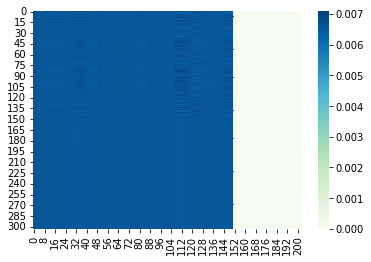


Epoch: 2/70


Train:   0%|          | 0/223 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 2/70: 
Train Loss 1.2418	 Learning Rate 0.0010


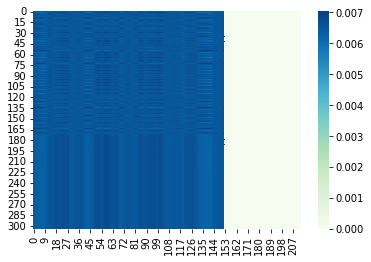


Epoch: 3/70


Train:   0%|          | 0/223 [00:00<?, ?it/s]

In [ ]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(config['epochs']):
    curr_lr = float(optimizer.param_groups[-1]['lr'])
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    # Call train and validate 
    train_loss, _, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)
    valid_dist, val_loss = validate(model, val_loader, criterion)

    # Print your metrics
    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_loss,
        curr_lr))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb
    wandb.log({"train_loss":train_loss, "valid_dist":valid_dist, "learning_Rate": curr_lr, "val_loss":val_loss})

    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step(val_loss)


    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here

        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'epoch': epoch}, '/content/drive/MyDrive/IDL/HW4/checkpoint_128.pth')

# Testing

In [ ]:
# Optional: Load your best model Checkpoint here
model1 = LAS(input_size=15, 
            encoder_hidden_size=256, 
            vocab_size=30, #len(VOCAB), 
            embed_size=256,
            decoder_hidden_size=512, 
            decoder_output_size=128,
            projection_size= 128
          ).to(device)
# model1.load_state_dict(torch.load('/content/drive/MyDrive/IDL/HW4/v12.pth')['model_state_dict'])
model1.load_state_dict(torch.load('/content/checkpoint.pth')['model_state_dict'])

<All keys matched successfully>

In [ ]:
VOCAB

['<sos>',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 "'",
 ' ',
 '<eos>']

In [ ]:
def make_output(h, lh, decoder_test, LABELS):
    beam_results, beam_scores, timesteps, out_seq_len = decoder_test.decode(h, seq_lens=lh) #TODO: What parameters would the decode function take in?
    batch_size = beam_results.shape[0]

    preds = []
    for i in range(batch_size): # Loop through each element in the batch
        h_sliced = beam_results[i][0][:out_seq_len[i][0]]#TODO: Obtain the beam results
        h_string = [str(LABELS[i]) for i in h_sliced]#TODO: Convert the beam results to phonemes
        h_string = "".join(h_string)
        preds.append(h_string)
    
    return preds

In [ ]:
# TODO: Create a testing function similar to validation 
def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")
    test_results = []

    for i, (x, lx) in enumerate(dataloader):

        x,lx= x.to(DEVICE),lx


        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions = predictions.argmax(dim=2)# TODO: How do you get the most likely character from each distribution in the batch?

        batch_bar.update()

        preds = []
        for j in range(len(greedy_predictions)):
          lst = [VOCAB[k] for k in greedy_predictions[j, :lx[j]]]
          if '<eos>' in lst:
            eos_idx = lst.index('<eos>')

            string = "".join(lst[1:eos_idx])
            preds.append(string)
          else: preds.append("".join(lst[1:]))
        
        test_results.extend(preds)

        del x, lx
        torch.cuda.empty_cache()

    batch_bar.close()
    #print(test_results)
    return test_results

# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle

In [ ]:
prediction = test(model, test_loader)

Test:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
prediction[0]

'HE BECAME A CONFUSED COMPLAINTATO GENTLE WISHER WHO HAD VANISHED BEHIND THE CURTAIN ON THE LEFT'

In [ ]:
torch.cuda.empty_cache()
#predictions = predict(test_loader, model1, decoder_test, LABELS)
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/IDL/HW4/data/hw4p2/test-clean/transcript/random_submission.csv')
df.label = prediction
df = df.rename(columns={"index": "id", "label": "label"})

df.to_csv('submission.csv', index = False)

!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "Message"

100% 301k/301k [00:02<00:00, 122kB/s]
Successfully submitted to Attention-Based Speech Recognition